<a href="https://colab.research.google.com/github/davidfague/Model-Reduction-Methods/blob/main/Expansion_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuron
!pip install neuron_reduce
!git clone https://github.com/davidfague/Model-Reduction-Methods.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 50.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'Model-Reduction-Methods'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 383 (delta 42), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (383/383), 1.31 MiB | 5.41 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [2]:
%cd Model-Reduction-Methods/

#import reduction and expansion functions
from test_neuron_reduce.subtree_reductor_func import subtree_reductor
from cable_expander_func import cable_expander

#import recording functions
from stylized_module.recorder import Recorder

#import analysis functions
from utils import make_seg_df,generate_stylized_geometry,make_reduced_seg_df,plot_morphology,check_connectivity,generate_reduced_cell_seg_coords, create_seg_var_report

import pandas as pd

/content/Model-Reduction-Methods


In [3]:
%cd expand_example
# compile the mod files
!nrnivmodl mod

/content/Model-Reduction-Methods/expand_example
/content/Model-Reduction-Methods/expand_example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> NMODL ../mod/CaDynamics_E2.mod
 -> NMODL ../mod/Ca_HVA.mod
 -> Compiling mod_func.cpp
 -> NMODL ../mod/Ca_LVAst.mod
Translating CaDynamics_E2.mod into /content/Model-Reduction-Methods/expand_example/x86_64/CaDynamics_E2.c
Translating Ca_LVAst.mod into /content/Model-Reduction-Methods/expand_example/x86_64/Ca_LVAst.c
Thread Safe
Thread Safe
Translating Ca_HVA.mod into /content/Model-Reduction-Methods/expand_example/x86_64/Ca_HVA.c
 -> NMODL ../mod/epsp.mod
 -> NMODL ../mod/Ih.mod
Thread Safe
Translating epsp.mod into /content/Model-Reduction-Methods/expand_example/x86_

In [4]:
# check mechanisms

In [5]:
%ls

cell1.asc  example_expand.py  L5PCtemplate.hoc  x86_64/
Cell.hoc   L5PCbiophys3.hoc   mod/


##Define The Cell

In [6]:
#Run the code
from __future__ import division
from neuron import gui,h
import numpy as np
import time
import matplotlib.pyplot as plt

#Create a L5_PC model
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')
h.load_file('L5PCbiophys3.hoc')
h.load_file("import3d.hoc")
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

Add synapses to the cell

In [7]:
#Add synapses to the model
synapses_list, netstims_list, netcons_list, randoms_list = [], [], [] ,[]

all_segments = [i for j in map(list,list(complex_cell.apical)) for i in j] + [i for j in map(list,list(complex_cell.basal)) for i in j]
len_per_segment = np.array([seg.sec.L/seg.sec.nseg for seg in all_segments])
rnd = np.random.RandomState(10)
for i in range(10000):
    seg_for_synapse = rnd.choice(all_segments,   p=len_per_segment/sum(len_per_segment)) #choose a random segment with probability based on the length of segment
    synapses_list.append(h.Exp2Syn(seg_for_synapse))
    if rnd.uniform()<0.85: # 85% synapses are excitatory
        e_syn, tau1, tau2, spike_interval, syn_weight = 0, 0.3, 1.8,  1000/2.5, 0.0016
    else: #inhibitory case
        e_syn, tau1, tau2, spike_interval, syn_weight = -86, 1,   8,   1000/15.0, 0.0008
    #set synaptic varibales
    synapses_list[i].e, synapses_list[i].tau1, synapses_list[i].tau2 = e_syn, tau1, tau2
    #set netstim variables
    netstims_list.append(h.NetStim())
    netstims_list[i].interval, netstims_list[i].number, netstims_list[i].start, netstims_list[i].noise = spike_interval, 9e9, 100, 1
    #set random
    randoms_list.append(h.Random())
    randoms_list[i].Random123(i)
    randoms_list[i].negexp(1)
    netstims_list[i].noiseFromRandom(randoms_list[i])       
    #set netcon varibales 
    netcons_list.append(h.NetCon(netstims_list[i], synapses_list[i] ))
    netcons_list[i].delay, netcons_list[i].weight[0] = 0, syn_weight

In [8]:
# track model information
make_seg_df(complex_cell,"segments_complex.csv")
# access model information
complex_segments_df = pd.read_csv("segments_complex.csv")
# # generate geometry file for possible stylized implementation
# generate_stylized_geometry(cell=complex_cell,savename='geom_complex.csv')

Simulate the complex cell

In [9]:
soma_v = h.Vector()
soma_v.record(complex_cell.soma[0](0.5)._ref_v)

time_v = h.Vector()
time_v.record(h._ref_t)

h.tstop = 1000
st = time.time()
h.run()
print('complex cell simulation time {:.4f}'.format(time.time()-st))
complex_cell_v = list(soma_v)

complex cell simulation time 41.8302


## Use Neuron_Reduce to turn each dendritic tree into a semi-equivalent cable

SectionList[8]
reduced cell simulation time 1.1739


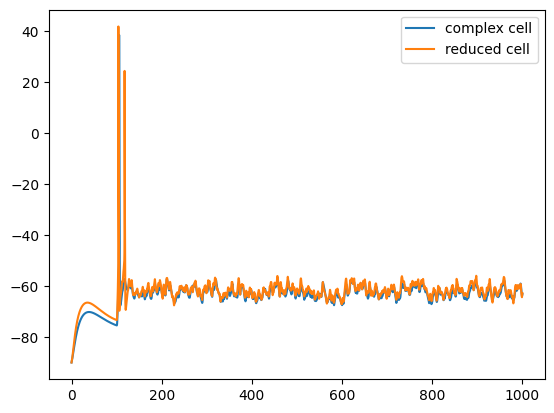

In [10]:
#apply Neuron_Reduce to simplify the cell
reduced_cell, synapses_list, netcons_list, txt = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
for r in randoms_list:r.seq(1) #reset random

#generate model 3d coordinates for plotting
generate_reduced_cell_seg_coords(reduced_cell)

# track model information
make_reduced_seg_df(reduced_cell,"segments_reduced.csv")

# access model information
reduced_segments_df=pd.read_csv("segments_reduced.csv")

# # generate geometry file for possible stylized implementation
# generate_stylized_geometry(cell=complex_cell,savename='geom_reduced.csv')

#Running the simulation again but now on the reduced cell
st = time.time()
h.run()
print('reduced cell simulation time {:.4f}'.format(time.time()-st))
reduced_celll_v = list(soma_v)

#plotting the results
plt.figure()

plt.plot(time_v, complex_cell_v, label='complex cell')
plt.plot(time_v, reduced_celll_v,  label='reduced cell')
plt.legend()
plt.show()

## Use cable_expander to turn each cable into an equivalent idealized dendritic tree

In [11]:
#trying to automate sections_to_expand and furcations_x after getting branching segment from seg_to_seg dictionary
#problem is that sections_to_expand entry is a string

#indicate the complex branching segment # may have to observe complex cell first
complex_branching_segment='L5PCtemplate[0].apic[36](0.961538)'
#get the reduced segment that the complex nexus branching segment mapped to
branching_seg=txt.get(complex_branching_segment)
branching_seg = branching_seg.replace("[0]", "",1)
branching_seg="reduced_cell.hoc_"+branching_seg
print('branching_seg: ',branching_seg)

# get section_to_expand and the furcation x loc
branching_seg_data=branching_seg.split('(')
section_to_expand=branching_seg_data[0]
furcation_x=branching_seg_data[1].strip(')')
#indicate lists for cable_expander()
sections_to_expand=[section_to_expand]
furcations_x=[furcation_x]
nbranches=[4] #choose nbranches #possible implementation could automatically count the number of times the seg immediately branches, but would not necessary account for later branching

branching_seg:  reduced_cell.hoc_model.apic[0](0.289004)


In [12]:
sections_to_expand = [reduced_cell.hoc_model.apic[0]]
furcations_x=[0.289004]

In [13]:
reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches, 
                                                                          synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

for r in randoms_list:r.seq(1) #reset random

sections_to_keep:  [L5PCtemplate[0].axon[0], model[0].dend[7], model[0].dend[6], model[0].dend[5], model[0].dend[4], model[0].dend[3], model[0].dend[2], model[0].dend[1], model[0].dend[0]]
sections_to_delete:  [model[0].apic[0]]
trunk_diam: 3.7176523208618155 |trunk_length: 698.0975328998376 |branch_diam: 1.475351301247016 |branch_length: 1081.914006306841
expanded_seg:  model[1].apic[0](0.0934238)
expanded_seg:  model[1].apic[0](0.27547)
expanded_seg:  model[1].apic[0](0.457518)
expanded_seg:  model[1].apic[0](0.63957)
expanded_seg:  model[1].apic[0](0.821625)


In [14]:
#recording variables
gNaTa_T = Recorder(obj_list = sim.cells[0].segments, var_name = 'gNaTa_t_NaTa_t')
ical = Recorder(obj_list = sim.cells[0].segments, var_name = 'ica_Ca_LVAst')
icah = Recorder(obj_list = sim.cells[0].segments, var_name = 'ica_Ca_HVA')
ih = Recorder(obj_list = sim.cells[0].segments, var_name = 'ihcn_Ih')


#Running the simulation again but now on the reduced cell
st = time.time()
h.run()
print('reduced cell simulation time {:.4f}'.format(time.time()-st))
expanded_cellll_v = list(soma_v)

ih_data = ih.as_numpy()
gNaTa_T_data = gNaTa_T.as_numpy()
icah_data = icah.as_numpy()
ical_data = ical.as_numpy()
v_dend = dend_v.as_numpy()

create_seg_var_report('v_report.h5', v_dend.T)
create_seg_var_report('Ca_HVA.ica_report.h5',icah_data.T)
create_seg_var_report('Ca_LVAst.ica_report.h5',ical_data.T)
create_seg_var_report('Ih.ihcn_report.h5',ih_data.T)
create_seg_var_report('inmda_report.h5',i_NMDA_df.T)
create_seg_var_report('NaTa_t.gNaTa_t_report.h5',gNaTa_T_data.T)


reduced cell simulation time 2.1846


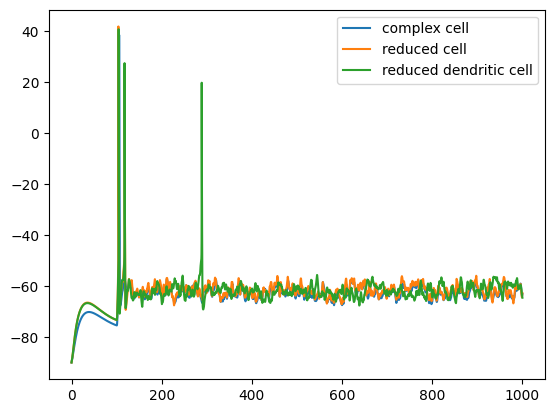

In [15]:
#plotting the results
plt.figure()

plt.plot(time_v, complex_cell_v, label='complex cell')
plt.plot(time_v, reduced_celll_v,  label='reduced cell')
plt.plot(time_v, expanded_cellll_v,  label='reduced dendritic cell')
plt.legend()
plt.show()

In [16]:
check_connectivity(reduced_dendritic_cell)

SOMA
L5PCtemplate[0].soma[0] children [model[0].dend[0], model[0].dend[1], model[0].dend[2], model[0].dend[3], model[0].dend[4], model[0].dend[5], model[0].dend[6], model[0].dend[7], L5PCtemplate[0].axon[0], model[1].apic[0]]
APICAL
model[1].apic[0] children [model[1].apic[4], model[1].apic[3], model[1].apic[2], model[1].apic[1]]
model[1].apic[4]
model[1].apic[3]
model[1].apic[2]
model[1].apic[1]
BASAL
model[0].dend[0]
model[0].dend[1]
model[0].dend[2]
model[0].dend[3]
model[0].dend[4]
model[0].dend[5]
model[0].dend[6]
model[0].dend[7]
AXONAL
L5PCtemplate[0].axon[0] children [L5PCtemplate[0].axon[1]]
L5PCtemplate[0].axon[1]


Analyze Cells

In [17]:
import math
# testing
def generate_reduced_cell_seg_coords(cell):
  '''
  WILL NEED TO BE EDITED FOR EXPANDED REDUCED CELL
  takes a cell that has no n3d() coordinates and gives new coordinates
  by choosing an arbitrary direction for the subtree to move
  '''
  parent_sections=[] #list for already seen parent_sections
  try: section_obj_list=cell.all
  except: section_obj_list=cell.hoc_model.all
  print(section_obj_list)
  axial=False
  for sec in section_obj_list:
    if sec.n3d() !=0 :
      if sec.parentseg() is not None:
        psec=sec.parentseg().sec
        parent_sections.append(psec)
        if psec==cell.soma:
          nbranch=1
        else:
          nbranch = len(psec.children())
        rot = 2 * math.pi/nbranch #one branch
        i=parent_sections.count(psec)
        length=sec.L
        diameter=sec.diam
        fullsecname = sec.name()
        sec_type = fullsecname.split(".")[1][:4]
        if sec_type == "apic":
          ang=np.random.normal(scale=0.1,loc=1.570796327)
        elif sec_type=="dend":
          ang=-np.random.uniform(low=0,high=np.pi)
        else:
          ang=0
        if axial == True:
          x = 0
          y = length*((ang>=0)*2-1)
        else:
          x = length * math.cos(ang)
          y = length * math.sin(ang)
        #find starting position
        pt0 = [psec.x3d(1), psec.y3d(1), psec.z3d(1)]
        pt1 = [0., 0., 0.]
        pt1[1] = pt0[1] + y
        pt1[0] = pt0[0] + x * math.cos(i * rot)
        pt1[2] = pt0[2] + x * math.sin(i * rot)
        sec.pt3dadd(*pt0, sec.diam)
        sec.pt3dadd(*pt1, sec.diam)

In [19]:
generate_reduced_cell_seg_coords(reduced_dendritic_cell)
make_reduced_seg_df(reduced_dendritic_cell,"segments_expanded.csv")
expanded_segments_df=pd.read_csv("segments_expanded.csv")

[L5PCtemplate[0].soma[0], model[0].dend[0], model[0].dend[1], model[0].dend[2], model[0].dend[3], model[0].dend[4], model[0].dend[5], model[0].dend[6], model[0].dend[7], L5PCtemplate[0].axon[0], L5PCtemplate[0].axon[1], model[1].apic[0], model[1].apic[4], model[1].apic[3], model[1].apic[2], model[1].apic[1]]


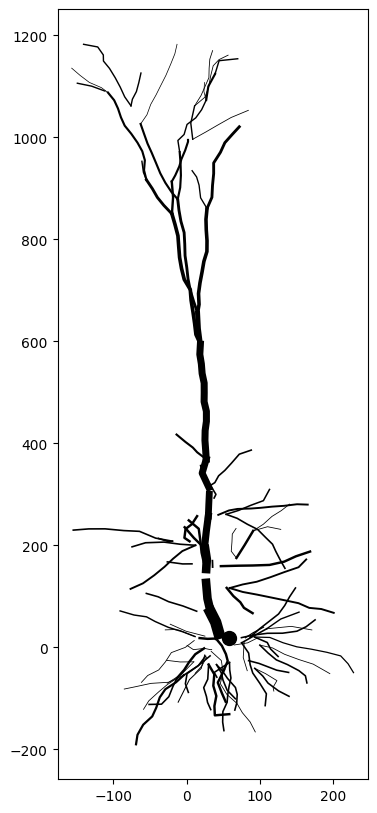

In [20]:
plot_morphology(complex_segments_df,'complex_morphology.svg')

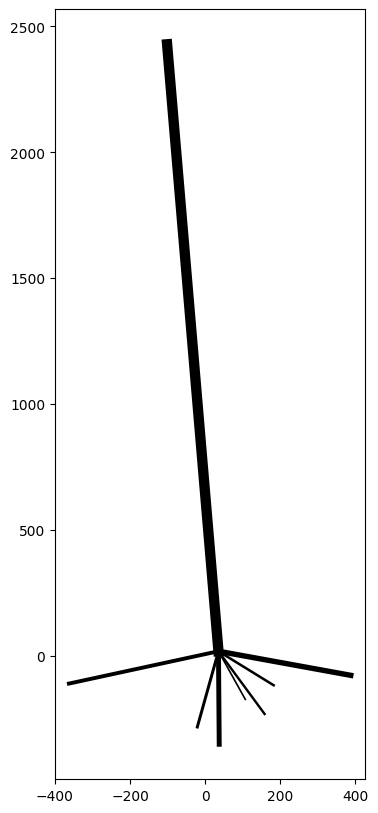

In [21]:
plot_morphology(reduced_segments_df,"reduced_morphology.svg")

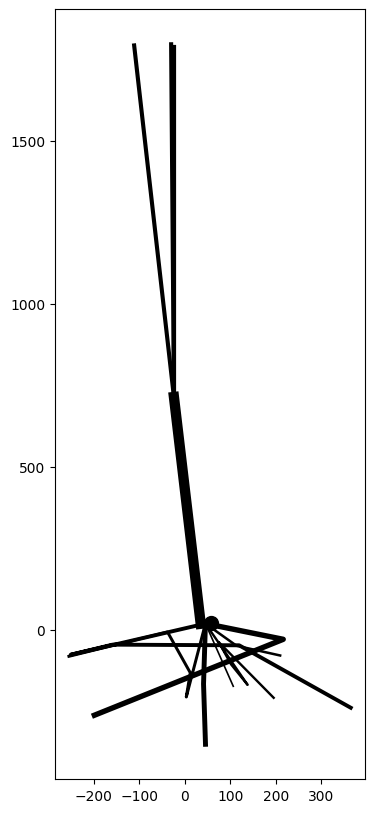

In [22]:
plot_morphology(expanded_segments_df,"expanded_morphology.svg")

In [ ]:
class cell_model():
  '''expand cell model'''
  def __init__(self,model,spike_threshold):
    self.all=model.all
    self.soma=model.soma
    self.apic=model.apic
    self.dend=model.dend
    self.axon=model.axon
    self.segments=[]
    self.injection=[]
    self.sec_id_lookup = {}  # dictionary from section type id to section index
    self.sec_id_in_seg = []  # index of the first segment of each section in the segment list
    self.__store_segments()
    self.__set_spike_recorder()

  def __calc_seg_coords(self):
    """Calculate segment coordinates for ECP calculation"""
    p0 = np.empty((self._nseg, 3))
    p1 = np.empty((self._nseg, 3))
    p05 = np.empty((self._nseg, 3))
    r = np.empty(self._nseg)
    for isec, sec in enumerate(self.all):
        iseg = self.sec_id_in_seg[isec]
        nseg = sec.nseg
        pt0 = np.array([sec.x3d(0), sec.y3d(0), sec.z3d(0)])
        pt1 = np.array([sec.x3d(1), sec.y3d(1), sec.z3d(1)])
        pts = np.linspace(pt0, pt1, 2 * nseg + 1)
        p0[iseg:iseg + nseg, :] = pts[:-2:2, :]
        p1[iseg:iseg + nseg, :] = pts[2::2, :]
        p05[iseg:iseg + nseg, :] = pts[1:-1:2, :]
        r[iseg:iseg + nseg] = sec.diam / 2
    self.seg_coords = {'dl': p1 - p0, 'pc': p05, 'r': r}

  def __store_segments(self):
    self.segments = []
    self.sec_id_in_seg = []
    nseg = 0
    for sec in self.all:
        self.sec_id_in_seg.append(nseg)
        nseg += sec.nseg
        for seg in sec:
            self.segments.append(seg)
            self.__store_point_processes(seg)
    self._nseg = nseg

  def __store_point_processes(self,seg):
    for pp in seg.point_processes:
        self.injection.append(pp)

  def __set_spike_recorder(self, threshold: Optional = None):
      if threshold is not None:
          self.spike_threshold = threshold
      if self.spike_threshold is None:
          self.spikes = None
      else:
          vec = h.Vector()
          nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
          nc.threshold = self.spike_threshold
          nc.record(vec)
          self.spikes = vec

In [ ]:
cell_model(reduced_dendritic_cell)

In [ ]:
class EcpMod(object):
    """
    A module for recording single cell transmembrane currents
    and calculating extracellular potential ECP
    """

    def __init__(self, cell: Union[StylizedCell, EcpCell],
                 electrode_positions: Union[List[List], np.ndarray] = [[0., 0., 0.]],
                 move_cell: Optional[Union[List,Tuple]] = None,
                 scale: float = 1.0, min_distance: Optional[float] = None) -> None:
        """
        cell: cell object
        electrode_positions: n-by-3 array of electrodes coordinates
        move_cell, scale, min_distance: see method 'calc_transfer_resistance'
        """
        self.cell = cell
        self.set_electrode_positions(electrode_positions)
        self.move_cell = move_cell
        self.scale = scale
        self.min_distance = min_distance
        self.ecp_cell = isinstance(cell, EcpCell)
        self.__record_im()

    # PRIVATE METHODS
    def __record_im(self) -> Recorder:
        """Enable extracellular mechanism in Neuron and record transmembrane currents"""
        if self.ecp_cell:
            self.im_rec = self.cell.im_rec
        else:
            h.cvode.use_fast_imem(1)
            for sec in self.cell.all:
                sec.insert('extracellular')  # insert extracellular
            for inj in self.cell.injection:
                if inj.rec_vec is None:
                    inj.setup_recorder()
            self.im_rec = Recorder(self.cell.segments, 'i_membrane_')

    # PUBLIC METHODS
    def set_electrode_positions(self, electrode_positions: Union[List[List], np.ndarray]) -> None:
        self.elec_coords = np.asarray(electrode_positions)
        if self.elec_coords.ndim != 2 or self.elec_coords.shape[1] != 3:
            raise ValueError("'electrode_positions' must be an n-by-3 2-D array")
        self.nelec = self.elec_coords.shape[0]
    
    def calc_transfer_resistance(self, move_cell: Optional[Union[List,Tuple]] = None,
                                 scale: float = 1.0, min_distance: Optional[float] = None,
                                 move_elec: Optional[bool] = False, sigma: float = 0.3,) -> None:
        """
        Precompute mapping from segment to electrode locations
        move_cell: list/tuple/2-by-3 array of (translate,rotate), rotate the cell followed by translating it
        scale: scaling factor of ECP magnitude
        min_distance: minimum distance allowed between segment and electrode, if specified
        sigma: resistivity of medium (mS/mm)
        move_elec: whether or not to relatively move electrodes for calculation
        """
        seg_coords = self.cell.seg_coords
        if move_cell is not None:
            move_cell = np.asarray(move_cell).reshape((2, 3))
        if move_elec and move_cell is not None:
            elec_coords = move_position(move_cell[0], move_cell[1], self.elec_coords, True)
        else:
            elec_coords = self.elec_coords
        if not move_elec and move_cell is not None:
            dl = move_position([0., 0., 0.], move_cell[1], seg_coords['dl'])
            pc = move_position(move_cell[0], move_cell[1], seg_coords['pc'])
        else:
            dl = seg_coords['dl']
            pc = seg_coords['pc']
        if min_distance is None:
            r = seg_coords['r']
        else:
            r = np.fmax(seg_coords['r'], min_distance)
        rr = r ** 2
        
        tr = np.empty((self.nelec, self.cell._nseg))
        for j in range(self.nelec):  # calculate mapping for each site on the electrode
            rel_pc = elec_coords[j, :] - pc  # distance between electrode and segment centers
            # compute dot product row-wise, the resulting array has as many rows as original
            r2 = np.einsum('ij,ij->i', rel_pc, rel_pc)
            rlldl = np.einsum('ij,ij->i', rel_pc, dl)
            dlmag = np.linalg.norm(dl, axis=1)  # length of each segment
            rll = abs(rlldl / dlmag)  # component of r parallel to the segment axis it must be always positive
            r_t2 = r2 - rll ** 2  # square of perpendicular component
            up = rll + dlmag / 2
            low = rll - dlmag / 2
            np.fmax(r_t2, rr, out=r_t2, where=low - r < 0)
            num = up + np.sqrt(up ** 2 + r_t2)
            den = low + np.sqrt(low ** 2 + r_t2)
            tr[j, :] = np.log(num / den) / dlmag  # units of (um) use with im_ (total seg current)
        tr *= scale / (4 * np.pi * sigma)
        return tr

    def calc_im(self, index: Optional = None) -> np.ndarray:
        """Calculate transmembrane current after simulation. Unit: nA."""
        index = slice(None) if index is None else index
        im = self.im_rec.as_numpy(copy=False)[:, index].copy()
        for inj in self.cell.injection:
            im[inj.get_segment_id(), :] -= inj.rec_vec.as_numpy()[index]
        return im

    def calc_ecp(self, index: Optional = None, **kwargs) -> np.ndarray:
        """Calculate ECP after simulation. Unit: mV."""
        kwargs0 = {
                    'move_cell': self.move_cell,
                    'scale': self.scale,
                    'min_distance': self.min_distance,
                   }
        kwargs0.update(kwargs)
        tr = self.calc_transfer_resistance(**kwargs0)
        im = self.calc_im(index=index)
        return tr @ im

    def calc_ecps(self, move_cell: Optional[List] = None, index: Optional = None, **kwargs) -> np.ndarray:
        """Calculate ECP with multiple positions after simulation. Unit: mV."""
        kwargs0 = {
                    'scale': self.scale,
                    'min_distance': self.min_distance,
                   }
        kwargs0.update(kwargs)
        if move_cell is None:
            move_cell = [self.move_cell]
        im = self.calc_im(index=index)
        ecp = []
        for mc in move_cell:
            ecp.append(self.calc_transfer_resistance(move_cell=mc, **kwargs0) @ im)
        return np.stack(ecp, axis=0)